# **English - Hindi:**

### **Library Installs:**

In [ ]:
pip install indic-nlp-library


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.1 MB/s eta 0:00:00


### **Imports:**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import json
import numpy as np
import re
import spacy
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize import indic_tokenize
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import math
from tqdm import tqdm
import csv
from torch.optim.lr_scheduler import ReduceLROnPlateau
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### **Data Loading from JSON files:**

In [ ]:
TRAIN_PATH = 'train_data1.json'
TEST_PATH = 'test_data1_final.json'

with open(TRAIN_PATH, 'r', encoding='utf-8') as file:
    data = json.load(file)

source_sentences_train = []
target_sentences_train = []

source_sentences_val = []
target_sentences_val = []

id_train = []
id_val = []

for language_pair, language_data in data.items():
    if(language_pair == "English-Hindi"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"  Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              target = entry_data["target"]
              if (data_type == "Validation"):
                source_sentences_val.append(source)
                target_sentences_val.append(target)
                id_val.append(entry_id)
              else:
                source_sentences_train.append(source)
                target_sentences_train.append(target)
                id_train.append(entry_id)

with open(TEST_PATH, 'r', encoding='utf-8') as file:
    data = json.load(file)

for language_pair, language_data in data.items():
    if(language_pair == "English-Hindi"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"  Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              if (data_type == "Test"):
                source_sentences_val.append(source)
                id_val.append(entry_id)

Language Pair: English-Hindi
  Data Type: Train
Language Pair: English-Hindi
  Data Type: Test


### **Data PreProcessing:**

**Reference:** https://doi.org/10.48550/arXiv.1409.3215

In this paper authors verified that reversing the source sentences while doing machine translation improved the results. I have taken this insight and used in my code.

> `"Finally, we found that reversing the order of the words in all source sentences (but not target sentences) improved the LSTM's performance markedly, because doing so introduced many short term dependencies between the source and the target sentence which made the optimization problem easier."`


**English Preprocessing:**
1. Sentences are converted to lowercase.
2. Each sentence is tokenized using spaCy, retaining only alphabetical tokens (removing punctuation and numbers).
3. The order of tokens is reversed in each sentence.

**Hindi Preprocessing:**
1. Sentences are normalized using the IndicNormalizer to handle inconsistencies like Unicode normalization.
2. Numbers and punctuation are removed.
3. Sentences are tokenized using a trivial tokenizer from Indic NLP library which is suitable for Indic languages.


In [ ]:
nlp = spacy.load("en_core_web_sm")

def preprocess_english(sentences):
    def preprocess_and_remove_punctuation(sentence):
        doc = nlp(sentence.lower())
        tokens = [token.text for token in doc if token.is_alpha]
        return tokens[::-1]
    tokenized_sentences = [preprocess_and_remove_punctuation(sentence) for sentence in sentences]
    return tokenized_sentences

def preprocess_hindi(sentences):
    normalizer = IndicNormalizerFactory().get_normalizer("hi")
    processed_sentences = []
    for sentence in sentences:
        normalized_sentence = normalizer.normalize(sentence)
        cleaned_sentence = ''.join([char for char in normalized_sentence if not char.isdigit() and char not in string.punctuation])
        tokens = list(indic_tokenize.trivial_tokenize(cleaned_sentence))
        processed_sentences.append(tokens)
    return processed_sentences


target_sentences_train = [re.sub(r'[a-zA-Z]', '', hi) for hi in target_sentences_train]

en_train = preprocess_english(source_sentences_train)
en_test = preprocess_english(source_sentences_val)
de_train = preprocess_hindi(target_sentences_train)
de_test = preprocess_hindi(target_sentences_val)

for i in range(10):
    print(en_train[i])
    print(de_train[i])
    print('\n')

['calendar', 'my', 'on', 'everything', 'cancel']
['मेरे', 'कैलेंडर', 'पर', 'सब', 'कुछ', 'रद्द', 'करें']


['vasocodilation', 'prevent', 'to', 'and', 'tone', 'muscle', 'vascular', 'regulate', 'to', 'is', 'hormones', 'these', 'of', 'function', 'important', 'an', 'am', 'around', 'level', 'low', 'a', 'reaching', 'evening', 'the', 'during', 'off', 'taper', 'and', 'morning', 'the', 'during', 'peak', 'their', 'at', 'are', 'levels', 'hormone', 'adrenal']
['अधिवृक्क', 'के', 'हार्मोन', 'का', 'स्तर', 'प्रातःकाल', 'में', 'अपने', 'शिखर', 'पर', 'होता', 'है', 'और', 'लगभग', 'दोपहर', 'बजे', 'एक', 'निम्न', 'स्तर', 'पर', 'पहुंचते', 'हुए', 'संध्याकाल', 'में', 'धीरेधीरे', 'कम', 'हो', 'जाता', 'है', '।', 'इन', 'हार्मोनों', 'का', 'वाहिकीय', 'मांसपेशी', 'के', 'तान', 'को', 'नियंत्रित', 'करने', 'और', 'वाहिकाविस्फार', 'से', 'बचाने', 'का', 'एक', 'महत्त्वपूर्ण']


['grams', 'tola', 'per', 'meters', 'yards', 'being', 'quality', 'the', 'surat', 'from', 'obtained', 'are', 'threads', 'golden']
['स्वर्ण', 'धागे', 'सूरत'

**Building Vocabulary:**

Created vocabularies for English and Hindi by collecting all unique tokens from the datasets and adds PAD, SOS,EOS. Then i generated mappings for word-to-index and index-to-word conversions which will be helpful during model training.

In [ ]:
en_index2word = ["<PAD>", "<SOS>", "<EOS>"]
de_index2word = ["<PAD>", "<SOS>", "<EOS>"]
en_vocab = set(en_index2word)
de_vocab = set(de_index2word)
for ds in [en_train, en_test]:
    for sent in ds:
        en_vocab.update(sent)
for ds in [de_train, de_test]:
    for sent in ds:
        de_vocab.update(sent)

en_index2word = list(en_vocab)
de_index2word = list(de_vocab)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
en_word2index = {token: idx for idx, token in enumerate(en_index2word)}
de_word2index = {token: idx for idx, token in enumerate(de_index2word)}

### **Data Analysis and Data Loading:**

**Sentence length distribution:** During model training we have to choose maximum sentence length, This plot helps us in understanding distribution of sentence lengths in the datasets. I have marked the 90th percentile as a reference. Based on the visualizations we can choose max sequence length as 30.

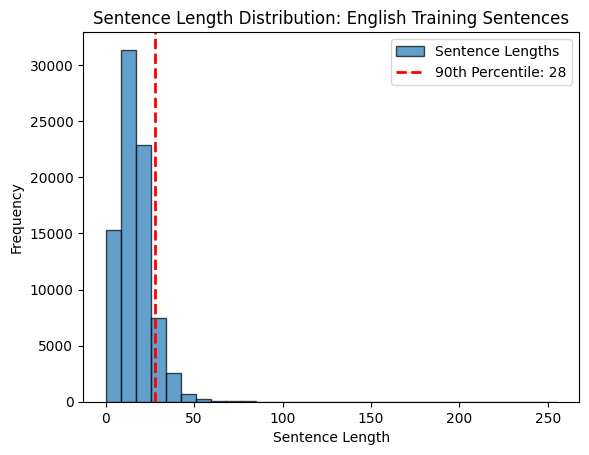

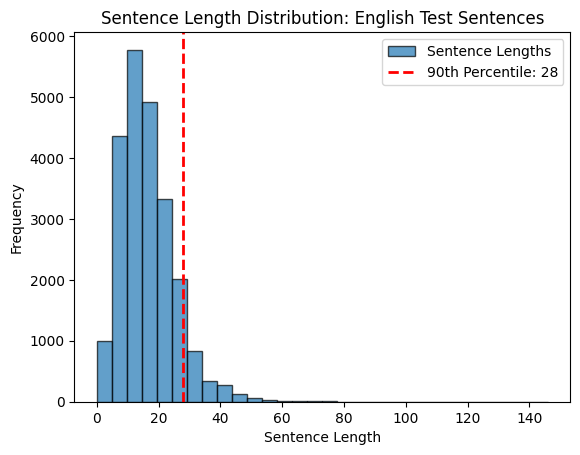

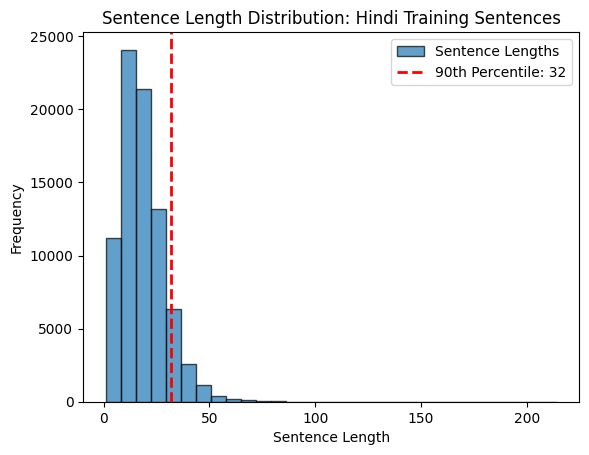

In [ ]:
def get_sentence_lengths(dataset):
    return [len(sentence) for sentence in dataset]

def plot_sentence_length_distribution_with_percentile(lengths, title):
    percentile_90 = np.percentile(lengths, 90)  # Calculate the 90th percentile
    plt.hist(lengths, bins=30, edgecolor='black', alpha=0.7, label="Sentence Lengths")
    plt.axvline(percentile_90, color='red', linestyle='dashed', linewidth=2, label=f"90th Percentile: {percentile_90:.0f}")
    plt.title(f"Sentence Length Distribution: {title}")
    plt.xlabel("Sentence Length")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

en_train_lengths = get_sentence_lengths(en_train)
en_test_lengths = get_sentence_lengths(en_test)
de_train_lengths = get_sentence_lengths(de_train)
de_test_lengths = get_sentence_lengths(de_test)

plot_sentence_length_distribution_with_percentile(en_train_lengths, "English Training Sentences")
plot_sentence_length_distribution_with_percentile(en_test_lengths, "English Test Sentences")
plot_sentence_length_distribution_with_percentile(de_train_lengths, "Hindi Training Sentences")


In [ ]:
def analyze_vocab(vocab):
    print(f"Total unique tokens: {len(vocab)}")
    print()

analyze_vocab(en_vocab)
analyze_vocab(de_vocab)

Total unique tokens: 64778

Total unique tokens: 69059



In [ ]:
def print_sentence_stats(lengths, dataset_name):
    print(f"{dataset_name} Sentence Length Statistics")
    print(f"Min Length: {min(lengths)}")
    print(f"Max Length: {max(lengths)}")
    print(f"Mean Length: {np.mean(lengths):.2f}")
    print(f"Median Length: {np.median(lengths)}")
    print()

print_sentence_stats(en_train_lengths, "English Training")
print_sentence_stats(en_test_lengths, "English Test")
print_sentence_stats(de_train_lengths, "Hindi Training")

English Training Sentence Length Statistics
Min Length: 0
Max Length: 255
Mean Length: 16.31
Median Length: 15.0

English Test Sentence Length Statistics
Min Length: 0
Max Length: 146
Mean Length: 16.34
Median Length: 15.0

Hindi Training Sentence Length Statistics
Min Length: 1
Max Length: 214
Mean Length: 18.70
Median Length: 17.0



In [ ]:
max_seq_len = int(np.percentile([len(sent) for sent in en_train + de_train], 90))
print(f"90th percentile sentence length of 90th percentile: {max_seq_len}")

90th percentile sentence length: 30


1. The pad_sequence function creates fixed-length sequences by adding SOS and EOS tokens, padding with PAD tokens, and truncating to max_len.

2. NMTDataset class processes source-target pairs into padded tensors for use in training.

3. DataLoaders batch the datasets for efficient training and validation.

In [ ]:
def pad_sequence(seq, vocab, max_len):
    padded_seq = [vocab["<SOS>"]] + [vocab.get(word, vocab["<PAD>"]) for word in seq[:max_len - 2]] + [vocab["<EOS>"]]
    padded_seq += [vocab["<PAD>"]] * (max_len - len(padded_seq))
    return padded_seq[:max_len]

class NMTDataset(Dataset):
    def __init__(self, source, target, source_vocab, target_vocab, max_len):
        self.source = [pad_sequence(sent, source_vocab, max_len) for sent in source]
        self.target = [pad_sequence(sent, target_vocab, max_len) for sent in target]

    def __len__(self):
        return len(self.source)

    def __getitem__(self, idx):
        return torch.tensor(self.source[idx]), torch.tensor(self.target[idx])

BATCH_SIZE = 64
MAX_SEQ_LEN = 30
train_src, val_src, train_tgt, val_tgt = train_test_split(en_train, de_train, test_size=0.1, random_state=42)
train_dataset = NMTDataset(train_src, train_tgt, en_word2index, de_word2index, MAX_SEQ_LEN)
val_dataset = NMTDataset(val_src, val_tgt, en_word2index, de_word2index, MAX_SEQ_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


### **Model Architecture:**

**Reference:** https://www.kaggle.com/datasets/thanakomsn/glove6b300dtxt

I have used glove embeddings of 300 dimensions present in this file.
These embeddings will be initial weights for the embedding layer, which will be updated during training .

In [ ]:
def load_glove_embeddings(file_path, vocab, embedding_dim):
    embeddings = np.random.uniform(-0.1, 0.1, (len(vocab), embedding_dim))
    embeddings[vocab["<PAD>"]] = np.zeros(embedding_dim)
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            if word in vocab:
                embeddings[vocab[word]] = vector
    return embeddings

glove_path = "glove.6B.300d.txt"
embedding_dim = 300
source_embeddings = load_glove_embeddings(glove_path, en_word2index, embedding_dim)
target_embeddings = load_glove_embeddings(glove_path, de_word2index, embedding_dim)


**Positional Embedding:** Next I created a class to create position-based embeddings for the data using sine and cosine to encode information about token positions. It calculates sine values for even positions and cosine values for odd positions in the embedding dimension. These embeddings are stored as a buffer and added to the input tensor during the forward pass. It ensures sequences up to a certain length get meaningful positional information for our Transformer model.

In [ ]:
class PositionalEncodingSinusoidal(nn.Module):
    def __init__(self, embedding_dimension, maximum_sequence_length):
        super(PositionalEncodingSinusoidal, self).__init__()
        positions = torch.arange(0, maximum_sequence_length).unsqueeze(1).float()
        division_term = torch.exp(torch.arange(0, embedding_dimension, 2).float() * -(math.log(10000.0) / embedding_dimension))
        positional_embeddings = torch.zeros(maximum_sequence_length, embedding_dimension)
        positional_embeddings[:, 0::2] = torch.sin(positions * division_term) #Using sine for even indices (0, 2, 4, ...)
        positional_embeddings[:, 1::2] = torch.cos(positions * division_term) #Using cosine for odd indices (1, 3, 5, ...).
        self.register_buffer('positional_embeddings', positional_embeddings)

    def forward(self, input_tensor):
        sequence_length = input_tensor.size(1)
        return input_tensor + self.positional_embeddings[:sequence_length, :].unsqueeze(0).to(input_tensor.device)

NeuralTransformer class Initializes source and target embeddings with glove embeddings and adds sinusoidal positional encodings. Then i have built transformer model using PyTorch's nn.Transformer. This code processes input sequences through embeddings, adds positional encodings, and the transformer module with attention masks.Finally it outputs predictions by applying a linear layer to the transformer's output for the target vocabulary.

**Reference:** https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

In [ ]:

class NeuralTransformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, embedding_dimension, attention_heads, encoder_layers, decoder_layers, dropout_rate, maximum_sequence_length, source_embeddings=None, target_embeddings=None):
        super(NeuralTransformer, self).__init__()

        # Initialize source and target embeddings
        self.source_embedding = nn.Embedding(source_vocab_size, embedding_dimension)
        self.target_embedding = nn.Embedding(target_vocab_size, embedding_dimension)

        if source_embeddings is not None:
            self.source_embedding.weight.data.copy_(torch.tensor(source_embeddings))
            self.source_embedding.weight.requires_grad = True

        if target_embeddings is not None:
            self.target_embedding.weight.data.copy_(torch.tensor(target_embeddings))
            self.target_embedding.weight.requires_grad = True

        self.positional_encoding = PositionalEncodingSinusoidal(embedding_dimension, maximum_sequence_length)

        self.transformer_core = nn.Transformer(
            d_model=embedding_dimension,
            nhead=attention_heads,
            num_encoder_layers=encoder_layers,
            num_decoder_layers=decoder_layers,
            dropout=dropout_rate,
            batch_first=True
        )
        self.output_layer = nn.Linear(embedding_dimension, target_vocab_size)

    def forward(self, source_sequence, target_sequence):
        embedded_source = self.positional_encoding(self.source_embedding(source_sequence))
        embedded_target = self.positional_encoding(self.target_embedding(target_sequence))
        source_mask = self.transformer_core.generate_square_subsequent_mask(source_sequence.size(1)).to(device)
        target_mask = self.transformer_core.generate_square_subsequent_mask(target_sequence.size(1)).to(device)
        transformer_output = self.transformer_core(embedded_source, embedded_target, src_mask=source_mask, tgt_mask=target_mask)
        return self.output_layer(transformer_output)



### **Training and Evaluating the model:**

sentence_translation translates source sentences into target sentences by using a trained model. It tokenises given input sentence and does all the necessary pre-processing like padding or truncation of the sentence and then iteratively generates tokens in the target language by feeding in the source tensor and the latest predicted target tokens into the model until the end-of-sequence token (<EOS>) is reached or the maximum length is exceeded.

In [ ]:
def sentence_translation(input_sentence, trained_model, source_vocabulary, target_vocabulary, maximum_length):
    trained_model.eval()
    tokenized_input = pad_sequence(input_sentence, source_vocabulary, maximum_length)
    source_tensor = torch.tensor(tokenized_input).unsqueeze(0).to(device)
    target_tokens = [target_vocabulary["<SOS>"]]
    for _ in range(maximum_length):
        target_tensor = torch.tensor(target_tokens).unsqueeze(0).to(device)
        with torch.no_grad():
            predicted_output = trained_model(source_tensor, target_tensor)
        next_predicted_token = predicted_output.argmax(2)[:, -1].item()
        target_tokens.append(next_predicted_token)
        if next_predicted_token == target_vocabulary["<EOS>"]:
            break
    return [list(target_vocabulary.keys())[tok] for tok in target_tokens[1:-1]]

This function will calculate the performance of a trained model on a validation dataset. The function processes batches of data from validation_loader. On every batch, it uses the model to make predictions, then calculates the loss using a provided loss_function and finds the total validation loss.

In [ ]:
def validate_model(trained_model, validation_loader, loss_function):
    trained_model.eval()
    cumulative_validation_loss = 0
    with torch.no_grad():
        for source_batch, target_batch in validation_loader:
            source_batch, target_batch = source_batch.to(device), target_batch.to(device)
            target_input_sequence = target_batch[:, :-1]
            target_expected_sequence = target_batch[:, 1:]
            with torch.cuda.amp.autocast():
                model_predictions = trained_model(source_batch, target_input_sequence)
                reshaped_predictions = model_predictions.reshape(-1, model_predictions.shape[-1])
                reshaped_targets = target_expected_sequence.reshape(-1)
                loss_per_batch = loss_function(reshaped_predictions, reshaped_targets)
            cumulative_validation_loss += loss_per_batch.item()
    return cumulative_validation_loss / len(validation_loader)

1. This function trains a Transformer-based model using mixed precision for efficiency on a GPU. (**Reference for mixed precision**:https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html )

2. Loss computation against target sequences will be performed using the given loss criterion. The estimated loss is backpropagated, and the parameters will be updated using the optimizer.

3. After every epoch there is a scheduler which based on the performance of the model on the validation set changes the learning rate.

4. If this is the best observed validation loss the model checkpoint will be saved, storing information above model state along with optimizer, scheduler, and scaler details.

5. Training will be stopped if the validation loss does not improve throughout three consecutive epochs to prevent overfitting .

In [ ]:
def train_transformer_model(model,training_data_loader,validation_data_loader,optimizer,scheduler,loss_criterion,num_epochs, device,source_vocab, target_vocab, max_sequence_length,save_path="best_model.pth"):
    scaler = torch.cuda.amp.GradScaler()
    best_validation_loss = float('inf')  # Keeps track of the best validation loss
    no_improvement_epochs = 0  # Counter for consecutive epochs without improvement

    for epoch in range(num_epochs):
        model.train()
        total_training_loss = 0
        progress_bar = tqdm(enumerate(training_data_loader),total=len(training_data_loader),desc=f"Epoch {epoch + 1}/{num_epochs}",unit="batch" )
        for batch_index, (source_batch, target_batch) in progress_bar:
            source_batch, target_batch = source_batch.to(device), target_batch.to(device)
            target_inputs = target_batch[:, :-1]
            target_outputs = target_batch[:, 1:]
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                model_predictions = model(source_batch, target_inputs)
                reshaped_predictions = model_predictions.reshape(-1, model_predictions.shape[-1])
                reshaped_targets = target_outputs.reshape(-1)
                batch_loss = loss_criterion(reshaped_predictions, reshaped_targets)
            scaler.scale(batch_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_training_loss += batch_loss.item()
            progress_bar.set_postfix(loss=batch_loss.item())
            if batch_index % 100 == 0:
                test_sentence = ["hello", "brother", "how", "are", "you"]
                translated_sentence = sentence_translation(
                    test_sentence, model, source_vocab, target_vocab, max_sequence_length
                )
                print(f"Batch {batch_index} Translation: {' '.join(test_sentence)} -> {' '.join(translated_sentence)}")
        average_training_loss = total_training_loss / len(training_data_loader)
        print(f"Epoch {epoch + 1} Training Loss: {average_training_loss:.4f}")
        validation_loss = validate_model(model, validation_data_loader, loss_criterion)
        print(f"Epoch {epoch + 1} Validation Loss: {validation_loss:.4f}")
        scheduler.step(validation_loss)

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            no_improvement_epochs = 0  # Reset counter

            # Saving the model checkpoint
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_validation_loss': best_validation_loss,
                'scaler_state_dict': scaler.state_dict()
            }, save_path)
            print(f"Model checkpoint saved at epoch {epoch + 1} with validation loss {validation_loss:.4f}.")
        else:
            no_improvement_epochs += 1  # Increment counter

        # Early stopping condition
        if no_improvement_epochs >= 3:
            print(f"Early stopping triggered after {no_improvement_epochs} consecutive epochs without improvement.")
            break

    print("Training complete.")

Initializing the model by passing hyperparameters and starting the training pipeline:

In [ ]:
BATCH_SIZE = 64
EMBED_DIM = 300
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
DROPOUT = 0.3
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralTransformer(
    source_vocab_size=len(en_word2index),target_vocab_size=len(de_word2index),embedding_dimension=embedding_dim, attention_heads=6,encoder_layers=6,
    decoder_layers=6,dropout_rate=0.1,maximum_sequence_length=MAX_SEQ_LEN,source_embeddings=source_embeddings, target_embeddings=target_embeddings
).to(device)


criterion = nn.CrossEntropyLoss(ignore_index=de_word2index["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

train_transformer_model(
    model=model,
    training_data_loader=train_loader,
    validation_data_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_criterion=criterion,
    num_epochs=NUM_EPOCHS,
    device=device,
    source_vocab=en_word2index,
    target_vocab=de_word2index,
    max_sequence_length=MAX_SEQ_LEN,
    save_path="best_model.pth"
)

random_sentence = en_test[0]
translated_sentence = sentence_translation(random_sentence, model, en_word2index, de_word2index, MAX_SEQ_LEN)
print(f"Source: {' '.join(random_sentence)}")
print(f"Translation: {' '.join(translated_sentence)}")

<ipython-input-13-46f60dfd13de>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50:   0%|          | 0/1137 [00:00<?, ?batch/s]<ipython-input-13-46f60dfd13de>:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50:   0%|          | 2/1137 [00:02<18:49,  1.00batch/s, loss=10.8]

Batch 0 Translation: hello brother how are you -> 


Epoch 1/50:   9%|▉         | 102/1137 [00:13<02:45,  6.26batch/s, loss=7.68]

Batch 100 Translation: hello brother how are you -> के के के के के के


Epoch 1/50:  18%|█▊        | 202/1137 [00:27<02:30,  6.20batch/s, loss=6.85]

Batch 200 Translation: hello brother how are you -> यह के लिए


Epoch 1/50:  27%|██▋       | 302/1137 [00:41<01:35,  8.75batch/s, loss=6.58]

Batch 300 Translation: hello brother how are you -> 


Epoch 1/50:  35%|███▌      | 402/1137 [00:54<01:34,  7.81batch/s, loss=6.6]

Batch 400 Translation: hello brother how are you -> क्या के लिए में एक


Epoch 1/50:  44%|████▍     | 502/1137 [01:05<01:30,  7.00batch/s, loss=6.41]

Batch 500 Translation: hello brother how are you -> क्या क्या है


Epoch 1/50:  53%|█████▎    | 602/1137 [01:17<01:09,  7.73batch/s, loss=6.5]

Batch 600 Translation: hello brother how are you -> क्या क्या में क्या है


Epoch 1/50:  62%|██████▏   | 702/1137 [01:30<00:57,  7.62batch/s, loss=6.29]

Batch 700 Translation: hello brother how are you -> क्या क्या क्या है


Epoch 1/50:  71%|███████   | 802/1137 [01:42<00:44,  7.51batch/s, loss=6.24]

Batch 800 Translation: hello brother how are you -> क्या आप आप आप हैं


Epoch 1/50:  79%|███████▉  | 902/1137 [01:55<00:35,  6.67batch/s, loss=6.13]

Batch 900 Translation: hello brother how are you -> क्या क्या क्या हैं


Epoch 1/50:  88%|████████▊ | 1002/1137 [02:08<00:17,  7.76batch/s, loss=6.01]

Batch 1000 Translation: hello brother how are you -> क्या आप क्या हैं


Epoch 1/50:  97%|█████████▋| 1102/1137 [02:20<00:04,  7.45batch/s, loss=6.18]

Batch 1100 Translation: hello brother how are you -> क्या आप आप क्या हैं


Epoch 1/50: 100%|██████████| 1137/1137 [02:24<00:00,  7.87batch/s, loss=6.03]
<ipython-input-13-46f60dfd13de>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 Training Loss: 6.6791
Epoch 1 Validation Loss: 6.0711
Model checkpoint saved at epoch 1 with validation loss 6.0711.


Epoch 2/50:   0%|          | 2/1137 [00:00<03:09,  5.99batch/s, loss=5.87]

Batch 0 Translation: hello brother how are you -> क्या आप क्या हैं


Epoch 2/50:   9%|▉         | 102/1137 [00:12<02:29,  6.90batch/s, loss=6.02]

Batch 100 Translation: hello brother how are you -> क्या क्या क्या हैं


Epoch 2/50:  18%|█▊        | 202/1137 [00:24<02:01,  7.72batch/s, loss=5.79]

Batch 200 Translation: hello brother how are you -> क्या आप क्या है


Epoch 2/50:  27%|██▋       | 302/1137 [00:37<01:50,  7.53batch/s, loss=5.84]

Batch 300 Translation: hello brother how are you -> क्या आप आप क्या हैं


Epoch 2/50:  35%|███▌      | 402/1137 [00:49<01:40,  7.33batch/s, loss=5.77]

Batch 400 Translation: hello brother how are you -> आप क्या हैं कि क्या हैं


Epoch 2/50:  44%|████▍     | 502/1137 [01:01<01:37,  6.50batch/s, loss=5.71]

Batch 500 Translation: hello brother how are you -> आप क्या हैं कि क्या है


Epoch 2/50:  53%|█████▎    | 602/1137 [01:14<01:12,  7.40batch/s, loss=5.49]

Batch 600 Translation: hello brother how are you -> आप आप को कैसे कर रहे हैं


Epoch 2/50:  62%|██████▏   | 702/1137 [01:26<00:56,  7.69batch/s, loss=5.43]

Batch 700 Translation: hello brother how are you -> आप मेरे की क्या हैं


Epoch 2/50:  71%|███████   | 802/1137 [01:38<00:50,  6.64batch/s, loss=5.37]

Batch 800 Translation: hello brother how are you -> आप मेरे पास हैं


Epoch 2/50:  79%|███████▉  | 902/1137 [01:50<00:37,  6.31batch/s, loss=5.32]

Batch 900 Translation: hello brother how are you -> आप कौन का नाम क्या है


Epoch 2/50:  88%|████████▊ | 1002/1137 [02:03<00:18,  7.42batch/s, loss=5.31]

Batch 1000 Translation: hello brother how are you -> आप कौन है कि क्या है


Epoch 2/50:  97%|█████████▋| 1102/1137 [02:15<00:04,  7.40batch/s, loss=5.46]

Batch 1100 Translation: hello brother how are you -> आप मेरे नाम हैं


Epoch 2/50: 100%|██████████| 1137/1137 [02:19<00:00,  8.12batch/s, loss=5.15]


Epoch 2 Training Loss: 5.6031
Epoch 2 Validation Loss: 5.3978
Model checkpoint saved at epoch 2 with validation loss 5.3978.


Epoch 3/50:   0%|          | 2/1137 [00:00<03:22,  5.62batch/s, loss=5.36]

Batch 0 Translation: hello brother how are you -> आप ईमेल को कैसे कर रहे हैं


Epoch 3/50:   9%|▉         | 102/1137 [00:12<02:17,  7.55batch/s, loss=4.95]

Batch 100 Translation: hello brother how are you -> आप मेरे ईमेल हैं


Epoch 3/50:  18%|█▊        | 202/1137 [00:25<02:19,  6.71batch/s, loss=4.98]

Batch 200 Translation: hello brother how are you -> आप ईमेल हैं


Epoch 3/50:  27%|██▋       | 302/1137 [00:37<01:56,  7.16batch/s, loss=5.24]

Batch 300 Translation: hello brother how are you -> आप ईमेल हैं कि क्या कैसे क्या हैं


Epoch 3/50:  35%|███▌      | 402/1137 [00:49<01:41,  7.22batch/s, loss=5.07]

Batch 400 Translation: hello brother how are you -> आप कौन हैं कि कैसे कैसे हैं


Epoch 3/50:  44%|████▍     | 502/1137 [01:02<01:20,  7.85batch/s, loss=5.12]

Batch 500 Translation: hello brother how are you -> आप ईमेल हैं


Epoch 3/50:  53%|█████▎    | 602/1137 [01:14<01:26,  6.22batch/s, loss=4.93]

Batch 600 Translation: hello brother how are you -> आप ईमेल हैं कि कैसे कौन हैं


Epoch 3/50:  62%|██████▏   | 702/1137 [01:26<00:55,  7.80batch/s, loss=5.11]

Batch 700 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 3/50:  71%|███████   | 802/1137 [01:39<00:43,  7.63batch/s, loss=5.09]

Batch 800 Translation: hello brother how are you -> आप राम को कैसे हैं


Epoch 3/50:  79%|███████▉  | 902/1137 [01:51<00:30,  7.73batch/s, loss=5.13]

Batch 900 Translation: hello brother how are you -> आप कौन हैं


Epoch 3/50:  88%|████████▊ | 1002/1137 [02:03<00:20,  6.54batch/s, loss=4.7]

Batch 1000 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 3/50:  97%|█████████▋| 1102/1137 [02:16<00:04,  7.23batch/s, loss=4.85]

Batch 1100 Translation: hello brother how are you -> आप ईमेल के बारे में कैसे हैं


Epoch 3/50: 100%|██████████| 1137/1137 [02:20<00:00,  8.10batch/s, loss=4.43]


Epoch 3 Training Loss: 4.9912
Epoch 3 Validation Loss: 4.9756
Model checkpoint saved at epoch 3 with validation loss 4.9756.


Epoch 4/50:   0%|          | 2/1137 [00:00<03:35,  5.27batch/s, loss=4.9]

Batch 0 Translation: hello brother how are you -> आप कौन हैं


Epoch 4/50:   9%|▉         | 102/1137 [00:12<02:30,  6.87batch/s, loss=4.63]

Batch 100 Translation: hello brother how are you -> आप मेरे पास कौन हैं


Epoch 4/50:  18%|█▊        | 202/1137 [00:25<02:03,  7.55batch/s, loss=4.52]

Batch 200 Translation: hello brother how are you -> आप कैसे के नाम हैं


Epoch 4/50:  27%|██▋       | 302/1137 [00:37<01:54,  7.31batch/s, loss=4.53]

Batch 300 Translation: hello brother how are you -> आप कौन हैं कि कौन कैसे


Epoch 4/50:  35%|███▌      | 402/1137 [00:49<01:48,  6.78batch/s, loss=4.6]

Batch 400 Translation: hello brother how are you -> आप कौन हैं


Epoch 4/50:  44%|████▍     | 502/1137 [01:01<01:24,  7.49batch/s, loss=4.39]

Batch 500 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 4/50:  53%|█████▎    | 602/1137 [01:14<01:12,  7.37batch/s, loss=4.22]

Batch 600 Translation: hello brother how are you -> आप कौन हैं कि राम कैसे है


Epoch 4/50:  62%|██████▏   | 702/1137 [01:26<00:55,  7.83batch/s, loss=4.78]

Batch 700 Translation: hello brother how are you -> आप ईमेल हैं


Epoch 4/50:  71%|███████   | 802/1137 [01:38<00:52,  6.39batch/s, loss=4.27]

Batch 800 Translation: hello brother how are you -> आप कौन हैं कि कौन क्या है


Epoch 4/50:  79%|███████▉  | 902/1137 [01:50<00:29,  7.88batch/s, loss=4.65]

Batch 900 Translation: hello brother how are you -> आप कौन हैं


Epoch 4/50:  88%|████████▊ | 1002/1137 [02:03<00:18,  7.49batch/s, loss=4.42]

Batch 1000 Translation: hello brother how are you -> आप राम को कैसे कैसे हैं


Epoch 4/50:  97%|█████████▋| 1102/1137 [02:15<00:04,  7.14batch/s, loss=4.15]

Batch 1100 Translation: hello brother how are you -> आप राम को कैसे कर रहे हैं


Epoch 4/50: 100%|██████████| 1137/1137 [02:19<00:00,  8.12batch/s, loss=4.28]


Epoch 4 Training Loss: 4.4965
Epoch 4 Validation Loss: 4.5990
Model checkpoint saved at epoch 4 with validation loss 4.5990.


Epoch 5/50:   0%|          | 2/1137 [00:00<03:37,  5.22batch/s, loss=4.15]

Batch 0 Translation: hello brother how are you -> आप राम का जन्मदिन कैसे कर सकते हैं


Epoch 5/50:   9%|▉         | 102/1137 [00:12<02:11,  7.88batch/s, loss=3.84]

Batch 100 Translation: hello brother how are you -> आप कैसे हैं


Epoch 5/50:  18%|█▊        | 202/1137 [00:25<02:22,  6.54batch/s, loss=4.27]

Batch 200 Translation: hello brother how are you -> आप कौन हैं


Epoch 5/50:  27%|██▋       | 302/1137 [00:37<01:51,  7.51batch/s, loss=4.17]

Batch 300 Translation: hello brother how are you -> आप कैसे के भाई हैं


Epoch 5/50:  35%|███▌      | 402/1137 [00:49<01:34,  7.78batch/s, loss=4.33]

Batch 400 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 5/50:  44%|████▍     | 502/1137 [01:02<01:21,  7.74batch/s, loss=4.37]

Batch 500 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 5/50:  53%|█████▎    | 602/1137 [01:14<01:19,  6.77batch/s, loss=4.11]

Batch 600 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 5/50:  62%|██████▏   | 702/1137 [01:26<00:56,  7.72batch/s, loss=3.98]

Batch 700 Translation: hello brother how are you -> आप कौन रहे हैं


Epoch 5/50:  71%|███████   | 802/1137 [01:39<00:44,  7.49batch/s, loss=3.85]

Batch 800 Translation: hello brother how are you -> आप राम कैसे हैं


Epoch 5/50:  79%|███████▉  | 902/1137 [01:52<00:32,  7.27batch/s, loss=3.93]

Batch 900 Translation: hello brother how are you -> आप राम का नाम कैसे हैं


Epoch 5/50:  88%|████████▊ | 1002/1137 [02:04<00:21,  6.34batch/s, loss=3.84]

Batch 1000 Translation: hello brother how are you -> आप कौन से कौन हैं


Epoch 5/50:  97%|█████████▋| 1102/1137 [02:16<00:04,  7.32batch/s, loss=3.93]

Batch 1100 Translation: hello brother how are you -> आप कौन कैसे हैं


Epoch 5/50: 100%|██████████| 1137/1137 [02:21<00:00,  8.04batch/s, loss=3.68]


Epoch 5 Training Loss: 4.0732
Epoch 5 Validation Loss: 4.3170
Model checkpoint saved at epoch 5 with validation loss 4.3170.


Epoch 6/50:   0%|          | 2/1137 [00:00<04:05,  4.62batch/s, loss=3.99]

Batch 0 Translation: hello brother how are you -> आप को कैसे हैं कि


Epoch 6/50:   9%|▉         | 102/1137 [00:12<02:23,  7.23batch/s, loss=3.78]

Batch 100 Translation: hello brother how are you -> आप कैसे हैं


Epoch 6/50:  18%|█▊        | 202/1137 [00:25<02:09,  7.23batch/s, loss=3.9]

Batch 200 Translation: hello brother how are you -> आप कौन से कैसे हैं


Epoch 6/50:  27%|██▋       | 302/1137 [00:37<01:55,  7.21batch/s, loss=3.79]

Batch 300 Translation: hello brother how are you -> आप राम हैं कि आप कैसे हैं


Epoch 6/50:  35%|███▌      | 402/1137 [00:50<01:49,  6.72batch/s, loss=4.05]

Batch 400 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 6/50:  44%|████▍     | 502/1137 [01:02<01:29,  7.06batch/s, loss=3.71]

Batch 500 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 6/50:  53%|█████▎    | 602/1137 [01:14<01:12,  7.40batch/s, loss=3.85]

Batch 600 Translation: hello brother how are you -> आप कैसे हैं कि राम है ।


Epoch 6/50:  62%|██████▏   | 702/1137 [01:27<00:55,  7.81batch/s, loss=3.58]

Batch 700 Translation: hello brother how are you -> आप कौन हैं


Epoch 6/50:  71%|███████   | 802/1137 [01:39<00:49,  6.71batch/s, loss=3.5]

Batch 800 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 6/50:  79%|███████▉  | 902/1137 [01:51<00:31,  7.55batch/s, loss=3.97]

Batch 900 Translation: hello brother how are you -> आप कौन से कितने हैं


Epoch 6/50:  88%|████████▊ | 1002/1137 [02:04<00:17,  7.71batch/s, loss=3.88]

Batch 1000 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 6/50:  97%|█████████▋| 1102/1137 [02:16<00:04,  7.55batch/s, loss=3.82]

Batch 1100 Translation: hello brother how are you -> आप कौन से कौन हैं


Epoch 6/50: 100%|██████████| 1137/1137 [02:20<00:00,  8.09batch/s, loss=3.53]


Epoch 6 Training Loss: 3.7039
Epoch 6 Validation Loss: 4.1041
Model checkpoint saved at epoch 6 with validation loss 4.1041.


Epoch 7/50:   0%|          | 2/1137 [00:00<03:14,  5.82batch/s, loss=3.31]

Batch 0 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 7/50:   9%|▉         | 102/1137 [00:12<02:30,  6.86batch/s, loss=3.37]

Batch 100 Translation: hello brother how are you -> आप कैसे हैं


Epoch 7/50:  18%|█▊        | 202/1137 [00:24<02:12,  7.08batch/s, loss=3.1]

Batch 200 Translation: hello brother how are you -> आप कैसे हैं कि कौन से है


Epoch 7/50:  27%|██▋       | 302/1137 [00:37<01:51,  7.50batch/s, loss=3.39]

Batch 300 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 7/50:  35%|███▌      | 402/1137 [00:49<01:35,  7.71batch/s, loss=3.12]

Batch 400 Translation: hello brother how are you -> आप कैसे हैं


Epoch 7/50:  44%|████▍     | 502/1137 [01:02<01:45,  6.01batch/s, loss=3.66]

Batch 500 Translation: hello brother how are you -> आप कैसे हैं कि आप कैसे हैं


Epoch 7/50:  53%|█████▎    | 602/1137 [01:14<01:09,  7.75batch/s, loss=3.38]

Batch 600 Translation: hello brother how are you -> आप कौन से हैं


Epoch 7/50:  62%|██████▏   | 702/1137 [01:26<00:58,  7.39batch/s, loss=3.4]

Batch 700 Translation: hello brother how are you -> आप कौन हैं कि भाई कैसे है


Epoch 7/50:  71%|███████   | 802/1137 [01:39<00:44,  7.45batch/s, loss=3.39]

Batch 800 Translation: hello brother how are you -> आप कैसे कितने का हैं


Epoch 7/50:  79%|███████▉  | 902/1137 [01:51<00:35,  6.66batch/s, loss=3.07]

Batch 900 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 7/50:  88%|████████▊ | 1002/1137 [02:03<00:17,  7.75batch/s, loss=3.29]

Batch 1000 Translation: hello brother how are you -> आप के भाई हैं


Epoch 7/50:  97%|█████████▋| 1102/1137 [02:16<00:04,  7.23batch/s, loss=3.21]

Batch 1100 Translation: hello brother how are you -> आप को कैसे कैसे कर रहे हैं


Epoch 7/50: 100%|██████████| 1137/1137 [02:20<00:00,  8.09batch/s, loss=3.78]


Epoch 7 Training Loss: 3.3753
Epoch 7 Validation Loss: 3.9315
Model checkpoint saved at epoch 7 with validation loss 3.9315.


Epoch 8/50:   0%|          | 2/1137 [00:00<03:13,  5.88batch/s, loss=3.28]

Batch 0 Translation: hello brother how are you -> आप का नाम कैसे हैं


Epoch 8/50:   9%|▉         | 102/1137 [00:12<02:14,  7.68batch/s, loss=3.25]

Batch 100 Translation: hello brother how are you -> आप कैसे कैसे हैं


Epoch 8/50:  18%|█▊        | 202/1137 [00:24<02:28,  6.30batch/s, loss=3.07]

Batch 200 Translation: hello brother how are you -> आप को कैसे कैसे कर रहे हैं


Epoch 8/50:  27%|██▋       | 302/1137 [00:37<01:48,  7.70batch/s, loss=2.71]

Batch 300 Translation: hello brother how are you -> आप कैसे भाई हैं


Epoch 8/50:  35%|███▌      | 402/1137 [00:49<01:42,  7.19batch/s, loss=3.06]

Batch 400 Translation: hello brother how are you -> आप कैसे हैं कि भाई कैसे है


Epoch 8/50:  44%|████▍     | 502/1137 [01:02<01:23,  7.58batch/s, loss=3.1]

Batch 500 Translation: hello brother how are you -> आप कैसे भाई हैं


Epoch 8/50:  53%|█████▎    | 602/1137 [01:14<01:16,  6.99batch/s, loss=3.22]

Batch 600 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 8/50:  62%|██████▏   | 702/1137 [01:26<00:58,  7.48batch/s, loss=3.13]

Batch 700 Translation: hello brother how are you -> आप कौन से भाई हैं


Epoch 8/50:  71%|███████   | 802/1137 [01:39<00:43,  7.69batch/s, loss=2.88]

Batch 800 Translation: hello brother how are you -> आप को कैसे हैं


Epoch 8/50:  79%|███████▉  | 902/1137 [01:51<00:34,  6.81batch/s, loss=3.09]

Batch 900 Translation: hello brother how are you -> आप कैसे हैं


Epoch 8/50:  88%|████████▊ | 1002/1137 [02:04<00:20,  6.45batch/s, loss=3.31]

Batch 1000 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 8/50:  97%|█████████▋| 1102/1137 [02:16<00:04,  7.45batch/s, loss=3.08]

Batch 1100 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 8/50: 100%|██████████| 1137/1137 [02:20<00:00,  8.07batch/s, loss=3.28]


Epoch 8 Training Loss: 3.0874
Epoch 8 Validation Loss: 3.8218
Model checkpoint saved at epoch 8 with validation loss 3.8218.


Epoch 9/50:   0%|          | 2/1137 [00:00<02:54,  6.52batch/s, loss=2.95]

Batch 0 Translation: hello brother how are you -> आप कैसे हैं


Epoch 9/50:   9%|▉         | 102/1137 [00:12<02:12,  7.82batch/s, loss=2.9]

Batch 100 Translation: hello brother how are you -> आप कैसे हैं


Epoch 9/50:  18%|█▊        | 202/1137 [00:25<01:59,  7.85batch/s, loss=3.08]

Batch 200 Translation: hello brother how are you -> आप कैसे हैं


Epoch 9/50:  27%|██▋       | 302/1137 [00:37<02:12,  6.32batch/s, loss=2.68]

Batch 300 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 9/50:  35%|███▌      | 402/1137 [00:49<01:34,  7.74batch/s, loss=2.73]

Batch 400 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 9/50:  44%|████▍     | 502/1137 [01:02<01:25,  7.46batch/s, loss=2.6]

Batch 500 Translation: hello brother how are you -> आप के भाई कैसे हैं


Epoch 9/50:  53%|█████▎    | 602/1137 [01:14<01:15,  7.05batch/s, loss=3.04]

Batch 600 Translation: hello brother how are you -> आप को कैसे कैसे कर रहे हैं


Epoch 9/50:  62%|██████▏   | 702/1137 [01:26<01:05,  6.65batch/s, loss=2.76]

Batch 700 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 9/50:  71%|███████   | 802/1137 [01:39<00:43,  7.76batch/s, loss=2.94]

Batch 800 Translation: hello brother how are you -> आप भाई कैसा हैं


Epoch 9/50:  79%|███████▉  | 902/1137 [01:51<00:31,  7.45batch/s, loss=2.77]

Batch 900 Translation: hello brother how are you -> आप भाई का हो रहे हैं


Epoch 9/50:  88%|████████▊ | 1002/1137 [02:04<00:18,  7.20batch/s, loss=2.68]

Batch 1000 Translation: hello brother how are you -> आप भाई का जन्मदिन कैसे कर रहे हैं


Epoch 9/50:  97%|█████████▋| 1102/1137 [02:16<00:05,  6.97batch/s, loss=2.62]

Batch 1100 Translation: hello brother how are you -> आप कैसे हैं


Epoch 9/50: 100%|██████████| 1137/1137 [02:20<00:00,  8.08batch/s, loss=3.01]


Epoch 9 Training Loss: 2.8228
Epoch 9 Validation Loss: 3.7459
Model checkpoint saved at epoch 9 with validation loss 3.7459.


Epoch 10/50:   0%|          | 2/1137 [00:00<03:38,  5.19batch/s, loss=2.71]

Batch 0 Translation: hello brother how are you -> आप के भाई हैं


Epoch 10/50:   9%|▉         | 102/1137 [00:12<02:25,  7.11batch/s, loss=2.57]

Batch 100 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 10/50:  18%|█▊        | 202/1137 [00:24<02:05,  7.43batch/s, loss=2.31]

Batch 200 Translation: hello brother how are you -> आप भाई के साथ क्या हैं


Epoch 10/50:  27%|██▋       | 302/1137 [00:37<01:47,  7.74batch/s, loss=2.57]

Batch 300 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 10/50:  35%|███▌      | 402/1137 [00:49<01:56,  6.32batch/s, loss=2.73]

Batch 400 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 10/50:  44%|████▍     | 502/1137 [01:01<01:29,  7.09batch/s, loss=2.75]

Batch 500 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 10/50:  53%|█████▎    | 602/1137 [01:14<01:08,  7.77batch/s, loss=2.73]

Batch 600 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 10/50:  62%|██████▏   | 702/1137 [01:26<00:56,  7.73batch/s, loss=2.45]

Batch 700 Translation: hello brother how are you -> आप कैसे हैं


Epoch 10/50:  71%|███████   | 802/1137 [01:39<00:53,  6.27batch/s, loss=2.79]

Batch 800 Translation: hello brother how are you -> आप भाई कैसे कर रहे हैं


Epoch 10/50:  79%|███████▉  | 902/1137 [01:51<00:30,  7.78batch/s, loss=2.83]

Batch 900 Translation: hello brother how are you -> आप कितने भाई हैं


Epoch 10/50:  88%|████████▊ | 1002/1137 [02:03<00:18,  7.26batch/s, loss=2.51]

Batch 1000 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 10/50:  97%|█████████▋| 1102/1137 [02:16<00:04,  7.78batch/s, loss=2.29]

Batch 1100 Translation: hello brother how are you -> आप कैसे हैं


Epoch 10/50: 100%|██████████| 1137/1137 [02:20<00:00,  8.09batch/s, loss=2.93]


Epoch 10 Training Loss: 2.5805
Epoch 10 Validation Loss: 3.6944
Model checkpoint saved at epoch 10 with validation loss 3.6944.


Epoch 11/50:   0%|          | 2/1137 [00:00<03:12,  5.91batch/s, loss=2.3]

Batch 0 Translation: hello brother how are you -> आप कैसे हैं


Epoch 11/50:   9%|▉         | 102/1137 [00:12<02:40,  6.47batch/s, loss=2.25]

Batch 100 Translation: hello brother how are you -> आप कितने बजे हैं


Epoch 11/50:  18%|█▊        | 202/1137 [00:25<02:23,  6.54batch/s, loss=2.18]

Batch 200 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 11/50:  27%|██▋       | 302/1137 [00:37<01:49,  7.61batch/s, loss=2.24]

Batch 300 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 11/50:  35%|███▌      | 402/1137 [00:50<01:37,  7.56batch/s, loss=2.46]

Batch 400 Translation: hello brother how are you -> आप कितने भाई हैं


Epoch 11/50:  44%|████▍     | 502/1137 [01:02<01:43,  6.12batch/s, loss=2.43]

Batch 500 Translation: hello brother how are you -> आप भाई के भाई कैसे हैं


Epoch 11/50:  53%|█████▎    | 602/1137 [01:14<01:19,  6.77batch/s, loss=2.45]

Batch 600 Translation: hello brother how are you -> आप के भाई कैसे हैं


Epoch 11/50:  62%|██████▏   | 702/1137 [01:27<00:58,  7.42batch/s, loss=2.49]

Batch 700 Translation: hello brother how are you -> आप हैं कि भाई कैसे है


Epoch 11/50:  71%|███████   | 802/1137 [01:40<00:43,  7.68batch/s, loss=2.4]

Batch 800 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 11/50:  79%|███████▉  | 902/1137 [01:52<00:35,  6.71batch/s, loss=2.61]

Batch 900 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 11/50:  88%|████████▊ | 1002/1137 [02:04<00:19,  7.04batch/s, loss=2.35]

Batch 1000 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 11/50:  97%|█████████▋| 1102/1137 [02:17<00:04,  7.83batch/s, loss=2.62]

Batch 1100 Translation: hello brother how are you -> आप क्या हैं


Epoch 11/50: 100%|██████████| 1137/1137 [02:21<00:00,  8.05batch/s, loss=2.81]


Epoch 11 Training Loss: 2.3480
Epoch 11 Validation Loss: 3.6731
Model checkpoint saved at epoch 11 with validation loss 3.6731.


Epoch 12/50:   0%|          | 2/1137 [00:00<03:11,  5.94batch/s, loss=2.3]

Batch 0 Translation: hello brother how are you -> आप कैसे हैं


Epoch 12/50:   9%|▉         | 102/1137 [00:12<02:21,  7.32batch/s, loss=2.27]

Batch 100 Translation: hello brother how are you -> आप का भाई कैसे कर रहे हैं


Epoch 12/50:  18%|█▊        | 202/1137 [00:25<02:23,  6.50batch/s, loss=2.23]

Batch 200 Translation: hello brother how are you -> आप क्या हैं


Epoch 12/50:  27%|██▋       | 302/1137 [00:37<01:49,  7.65batch/s, loss=2.21]

Batch 300 Translation: hello brother how are you -> आप कैसे हैं


Epoch 12/50:  35%|███▌      | 402/1137 [00:50<01:40,  7.30batch/s, loss=1.89]

Batch 400 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 12/50:  44%|████▍     | 502/1137 [01:02<01:24,  7.52batch/s, loss=1.97]

Batch 500 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 12/50:  53%|█████▎    | 602/1137 [01:14<01:19,  6.70batch/s, loss=2.22]

Batch 600 Translation: hello brother how are you -> आप कितने का हैं


Epoch 12/50:  62%|██████▏   | 702/1137 [01:27<00:57,  7.56batch/s, loss=2.29]

Batch 700 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 12/50:  71%|███████   | 802/1137 [01:39<00:42,  7.88batch/s, loss=2.16]

Batch 800 Translation: hello brother how are you -> आप कैसे हैं


Epoch 12/50:  79%|███████▉  | 902/1137 [01:52<00:32,  7.27batch/s, loss=2.08]

Batch 900 Translation: hello brother how are you -> आप कैसे हैं


Epoch 12/50:  88%|████████▊ | 1002/1137 [02:04<00:20,  6.69batch/s, loss=2.11]

Batch 1000 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 12/50:  97%|█████████▋| 1102/1137 [02:16<00:04,  7.54batch/s, loss=2.13]

Batch 1100 Translation: hello brother how are you -> आप हैं भाई कैसा हैं


Epoch 12/50: 100%|██████████| 1137/1137 [02:21<00:00,  8.06batch/s, loss=2.66]


Epoch 12 Training Loss: 2.1287
Epoch 12 Validation Loss: 3.6679
Model checkpoint saved at epoch 12 with validation loss 3.6679.


Epoch 13/50:   0%|          | 2/1137 [00:00<03:48,  4.97batch/s, loss=2.04]

Batch 0 Translation: hello brother how are you -> आप भाई के भाई हैं


Epoch 13/50:   9%|▉         | 102/1137 [00:12<02:15,  7.64batch/s, loss=1.83]

Batch 100 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 13/50:  18%|█▊        | 202/1137 [00:25<02:06,  7.39batch/s, loss=1.89]

Batch 200 Translation: hello brother how are you -> आप कितने भाई हैं


Epoch 13/50:  27%|██▋       | 302/1137 [00:38<02:04,  6.70batch/s, loss=2.09]

Batch 300 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 13/50:  35%|███▌      | 402/1137 [00:50<01:36,  7.64batch/s, loss=2.04]

Batch 400 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 13/50:  44%|████▍     | 502/1137 [01:02<01:24,  7.52batch/s, loss=1.65]

Batch 500 Translation: hello brother how are you -> आप कैसे हैं भाई


Epoch 13/50:  53%|█████▎    | 602/1137 [01:15<01:10,  7.59batch/s, loss=1.81]

Batch 600 Translation: hello brother how are you -> आप कितने भाई हैं


Epoch 13/50:  62%|██████▏   | 702/1137 [01:27<01:04,  6.75batch/s, loss=2.02]

Batch 700 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 13/50:  71%|███████   | 802/1137 [01:40<00:43,  7.67batch/s, loss=1.77]

Batch 800 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 13/50:  79%|███████▉  | 902/1137 [01:52<00:30,  7.60batch/s, loss=2.03]

Batch 900 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 13/50:  88%|████████▊ | 1002/1137 [02:05<00:20,  6.73batch/s, loss=1.99]

Batch 1000 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 13/50:  97%|█████████▋| 1102/1137 [02:17<00:05,  6.86batch/s, loss=1.97]

Batch 1100 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 13/50: 100%|██████████| 1137/1137 [02:21<00:00,  8.01batch/s, loss=1.95]


Epoch 13 Training Loss: 1.9203
Epoch 13 Validation Loss: 3.6906


Epoch 14/50:   0%|          | 1/1137 [00:00<03:25,  5.52batch/s, loss=5]

Batch 0 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 14/50:   9%|▉         | 102/1137 [00:12<02:14,  7.70batch/s, loss=1.57]

Batch 100 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 14/50:  18%|█▊        | 202/1137 [00:25<02:17,  6.82batch/s, loss=1.85]

Batch 200 Translation: hello brother how are you -> आप के भाई हैं


Epoch 14/50:  27%|██▋       | 302/1137 [00:37<01:46,  7.88batch/s, loss=1.55]

Batch 300 Translation: hello brother how are you -> आप क्या हैं


Epoch 14/50:  35%|███▌      | 402/1137 [00:49<01:36,  7.64batch/s, loss=1.42]

Batch 400 Translation: hello brother how are you -> आप क्या हैं भाई


Epoch 14/50:  44%|████▍     | 502/1137 [01:02<01:25,  7.44batch/s, loss=1.48]

Batch 500 Translation: hello brother how are you -> आप क्या हैं


Epoch 14/50:  53%|█████▎    | 602/1137 [01:14<01:20,  6.66batch/s, loss=1.57]

Batch 600 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 14/50:  62%|██████▏   | 702/1137 [01:27<00:57,  7.59batch/s, loss=1.72]

Batch 700 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 14/50:  71%|███████   | 802/1137 [01:39<00:43,  7.68batch/s, loss=1.88]

Batch 800 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 14/50:  79%|███████▉  | 902/1137 [01:52<00:34,  6.89batch/s, loss=1.82]

Batch 900 Translation: hello brother how are you -> आप क्या हैं


Epoch 14/50:  88%|████████▊ | 1002/1137 [02:04<00:20,  6.50batch/s, loss=1.53]

Batch 1000 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 14/50:  97%|█████████▋| 1102/1137 [02:16<00:04,  7.47batch/s, loss=1.77]

Batch 1100 Translation: hello brother how are you -> आप हैं भाई का जन्मदिन


Epoch 14/50: 100%|██████████| 1137/1137 [02:20<00:00,  8.07batch/s, loss=1.99]


Epoch 14 Training Loss: 1.7192
Epoch 14 Validation Loss: 3.7316


Epoch 15/50:   0%|          | 1/1137 [00:00<03:35,  5.28batch/s, loss=5.15]

Batch 0 Translation: hello brother how are you -> आप हैं कि भाई कैसे


Epoch 15/50:   9%|▉         | 102/1137 [00:12<02:28,  6.99batch/s, loss=1.44]

Batch 100 Translation: hello brother how are you -> आप क्या हैं भाई


Epoch 15/50:  18%|█▊        | 202/1137 [00:24<02:07,  7.36batch/s, loss=1.44]

Batch 200 Translation: hello brother how are you -> आप भाई के कितने हैं


Epoch 15/50:  27%|██▋       | 302/1137 [00:37<01:49,  7.65batch/s, loss=1.56]

Batch 300 Translation: hello brother how are you -> आप कितने भाई हैं


Epoch 15/50:  35%|███▌      | 402/1137 [00:49<01:51,  6.57batch/s, loss=1.26]

Batch 400 Translation: hello brother how are you -> आप कह रहे हैं


Epoch 15/50:  44%|████▍     | 502/1137 [01:01<01:32,  6.85batch/s, loss=1.6]

Batch 500 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 15/50:  53%|█████▎    | 602/1137 [01:14<01:10,  7.64batch/s, loss=1.61]

Batch 600 Translation: hello brother how are you -> आप कितने के हैं


Epoch 15/50:  62%|██████▏   | 702/1137 [01:26<00:55,  7.86batch/s, loss=1.34]

Batch 700 Translation: hello brother how are you -> आप क्या हैं


Epoch 15/50:  71%|███████   | 802/1137 [01:39<00:51,  6.55batch/s, loss=1.5]

Batch 800 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 15/50:  79%|███████▉  | 902/1137 [01:51<00:33,  7.09batch/s, loss=1.5]

Batch 900 Translation: hello brother how are you -> आप भाई कैसे हैं


Epoch 15/50:  88%|████████▊ | 1002/1137 [02:03<00:17,  7.62batch/s, loss=1.69]

Batch 1000 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 15/50:  97%|█████████▋| 1102/1137 [02:16<00:04,  7.75batch/s, loss=1.67]

Batch 1100 Translation: hello brother how are you -> आप हैं भाई कैसे


Epoch 15/50: 100%|██████████| 1137/1137 [02:20<00:00,  8.09batch/s, loss=1.49]


Epoch 15 Training Loss: 1.5293
Epoch 15 Validation Loss: 3.8012
Early stopping triggered after 3 consecutive epochs without improvement.
Training complete.
Source: well as computer a to feed somehow can we have you algorithm manual whatever so and logarithms manual in used are that steps the all perform can computer a that students assure to need we then and
Translation: तो आप । हैस्केल । में काम कर सकते हैं और । मैनुअल । में जो भी । मैनुअल । को रख सकते हैं वह । मैनुअल एल्गोरिथ्म


**Samle exmples of translations by trained model:**

In [ ]:
random_sentence = en_test[1]
translated_sentence = sentence_translation(random_sentence, model, en_word2index, de_word2index, MAX_SEQ_LEN)
print(f"Source: {' '.join(random_sentence)}")
print(f"Translation: {' '.join(translated_sentence)}")

Source: january of first the on scheduled event the for address the is what
Translation: भारत के प्रथम को निर्धारित कार्यक्रम के लिए निर्धारित एड्रेस क्या है


In [ ]:
random_sentence = en_test[2]
translated_sentence = sentence_translation(random_sentence, model, en_word2index, de_word2index, MAX_SEQ_LEN)
print(f"Source: {' '.join(random_sentence)}")
print(f"Translation: {' '.join(translated_sentence)}")

Source: district coimbatore the in kilometres square of area an in spread is park national gandhi indira
Translation: इंदिरा राष्ट्रीय उद्यान बंगलौर जिले में वर्ग किलोमीटर क्षेत्र में फैला हुआ है ।


In [ ]:
random_sentence = en_test[15]
translated_sentence = sentence_translation(random_sentence, model, en_word2index, de_word2index, MAX_SEQ_LEN)
print(f"Source: {' '.join(random_sentence)}")
print(f"Translation: {' '.join(translated_sentence)}")

Source: clothes colored light especially other with cloth that put not must you then color leaves cloth a if
Translation: यदि कपड़े की पत्तियों का रंग हरा तो उसकी रोशनी में न लगना चाहिए ।


**Code to load saved model checkpoint:**

In [ ]:
def load_model(save_path, model, optimizer, scheduler, device):
    checkpoint = torch.load(save_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    scaler = torch.cuda.amp.GradScaler()
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    print(f"Model loaded from checkpoint at epoch {checkpoint['epoch']} with validation loss {checkpoint['best_validation_loss']:.4f}.")
    return model, optimizer, scheduler, scaler

### **Generating Predictions for Test file:**

This class allows us to retrieve pair of an ID and its corresponding sentence by index.

In [ ]:
class TestDataset(Dataset):
    def __init__(self, ids, sentences):
        self.ids = ids
        self.sentences = sentences
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, index):
        return self.ids[index], self.sentences[index]

This function takes batch of sentences in one language and translates them into another using a model. It first fixes the length of input sentences and pads them. It starts off each sentence of the batch with <SOS> token and then iteratively predicts the next word until it hits either an <EOS> token or it hits its max sequence length. It finally converts the predicted tokens back into words using the target vocabulary and returns the translated sentences.

In [ ]:
def batch_translate(sentences, model, source_vocab, target_vocab, max_sequence_length):
    tokenized_sentences = [pad_sequence(preprocess_english([sentence])[0], source_vocab, max_sequence_length) for sentence in sentences]
    source_tensor = torch.tensor(tokenized_sentences).to(device)
    batch_size = len(sentences)
    target_tokens = torch.tensor([[target_vocab["<SOS>"]] for _ in range(batch_size)], device=device)
    translated_sentences = [[] for _ in range(batch_size)]

    with torch.set_grad_enabled(False):
        for _ in range(max_sequence_length):
            predicted_output = model(source_tensor, target_tokens)
            next_tokens = predicted_output.argmax(2)[:, -1]
            target_tokens = torch.cat([target_tokens, next_tokens.unsqueeze(1)], dim=1)
            for i, token in enumerate(next_tokens):
                if token.item() != target_vocab["<EOS>"]:
                    translated_sentences[i].append(token.item())
    translated_sentences = [" ".join([list(target_vocab.keys())[tok] for tok in sentence]) for sentence in translated_sentences]
    return translated_sentences

This function takes test sentences, translates them in a batch manner, and saves the results to a CSV file. First, it initializes dataloader to process the sentences in batches. Then for every batch it calls batch_translate function to translate sentences. It collects these translations and writes them to columns in a CSV file for their IDs and translations.

In [ ]:
def save_test_translations_to_csv_batch( test_ids, test_sentences, model, source_vocab, target_vocab, max_sequence_length,  output_csv_path, batch_size=32):
    dataset = TestDataset(test_ids, test_sentences)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
    translations = []
    model = model.to(device)

    for batch in tqdm(dataloader, total=len(dataloader), desc="Translating Sentences in Batches"):
        batch_ids, batch_sentences = zip(*batch)
        translated_sentences = batch_translate(sentences=batch_sentences,
            model=model,source_vocab=source_vocab,target_vocab=target_vocab,max_sequence_length=max_sequence_length)
        translations.extend(zip(batch_ids, translated_sentences))

    with open(output_csv_path, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "Translation"])
        writer.writerows(translations)
    print(f"Translations saved to {output_csv_path}")

Loads Test Json file and fetches all the test sentences and calls save_test_translations_to_csv_batch.

In [ ]:
TEST_PATH = 'test_data1_final.json'

source_sentences_test = []
id_test = []

with open(TEST_PATH, 'r', encoding='utf-8') as file:
    data = json.load(file)

for language_pair, language_data in data.items():
    if(language_pair == "English-Hindi"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              if (data_type == "Test"):
                source_sentences_test.append(source)
                id_test.append(entry_id)
print(f"Total test sentences: {len(source_sentences_test)}")


save_test_translations_to_csv_batch(
    test_ids=id_test,
    test_sentences=source_sentences_test,
    model=model,
    source_vocab=en_word2index,
    target_vocab=de_word2index,
    max_sequence_length=MAX_SEQ_LEN,
    output_csv_path="answersH.csv",
    batch_size=64
)


Language Pair: English-Hindi
Data Type: Test
Total test sentences: 23085


Translating Sentences in Batches: 100%|██████████| 361/361 [27:46<00:00,  4.62s/it]

Translations saved to answersH.csv


### **Merging Bengali-Hindi Results:**

In [ ]:
import pandas as pd
df1 = pd.read_csv("/content/answersB.csv")
df2= pd.read_csv("/content/answersH.csv")
df3 = pd.concat([df1, df2])

df3.to_csv('answersBH.csv', index = False)
filtered_data = pd.read_csv("/content/answersBH.csv")
answer = "/content/answer.csv"
with open(answer, "w") as f:
  f.writelines("ID\tTranslation\n")
  for i in range(filtered_data.shape[0]):
    f.writelines(f'{filtered_data["ID"][i]}\t"{filtered_data["Translation"][i]}"\n')